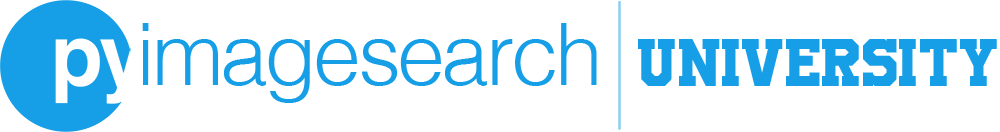

# Training an object detector from scratch in PyTorch
### by [PyImageSearch.com](http://www.pyimagesearch.com)

## Welcome to **[PyImageSearch University](https://pyimg.co/university)** Jupyter Notebooks!

This notebook is associated with the [Training an object detector from scratch in PyTorch](https://www.pyimagesearch.com/2021/11/01/training-an-object-detector-from-scratch-in-pytorch/) blog post published on 2021-11-01.

Only the code for the blog post is here. Most codeblocks have a 1:1 relationship with what you find in the blog post with two exceptions: (1) Python classes are not separate files as they are typically organized with PyImageSearch projects, and (2) Command Line Argument parsing is replaced with an `args` dictionary that you can manipulate as needed.

We recommend that you execute (press ▶️) the code block-by-block, as-is, before adjusting parameters and `args` inputs. Once you've verified that the code is working, you are welcome to hack with it and learn from manipulating inputs, settings, and parameters. For more information on using Jupyter and Colab, please refer to these resources:

*   [Jupyter Notebook User Interface](https://jupyter-notebook.readthedocs.io/en/stable/notebook.html#notebook-user-interface)
*   [Overview of Google Colaboratory Features](https://colab.research.google.com/notebooks/basic_features_overview.ipynb)

As a reminder, these PyImageSearch University Jupyter Notebooks are not for sharing; please refer to the **Copyright** directly below and **Code License Agreement** in the last cell of this notebook. 

Happy hacking!

*Adrian*

<hr>

***Copyright:*** *The contents of this Jupyter Notebook, unless otherwise indicated, are Copyright 2021 Adrian Rosebrock, PyimageSearch.com. All rights reserved. Content like this is made possible by the time invested by the authors. If you received this Jupyter Notebook and did not purchase it, please consider making future content possible by joining PyImageSearch University at https://pyimg.co/university today.*

### Download the code zip file

In [ ]:
!wget https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/object-detector-in-pytorch/object-detector-in-pytorch.zip
!unzip -qq object-detector-in-pytorch.zip

In [8]:
%cd object-detector-in-pytorch

C:\Users\msagardi\git_repositories\detection_segmentation_pytorch\04_basic_object_detection_pyimagesearch\02_trained\object-detector-in-pytorch


In [2]:
!unzip -qq dataset.zip

## Blog Post Code

### Import Packages

In [9]:
# import the necessary packages
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.data import Dataset
from torch.nn import CrossEntropyLoss
from torch.nn import MSELoss
from torch.nn import Dropout
from torch.nn import Identity
from torch.nn import Linear
from torch.nn import Module
from torch.nn import ReLU
from torch.nn import Sequential
from torch.nn import Sigmoid
from torch.optim import Adam
from torchvision.models import resnet50
from sklearn.model_selection import train_test_split
from imutils import paths
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch
import time
import mimetypes
import imutils
import cv2
import os

### Function to display images in Jupyter Notebooks and Google Colab

In [10]:
def plt_imshow(title, image):
    # convert the image frame BGR to RGB color space and display it
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.title(title)
    plt.grid(False)
    plt.show()

### Creating our configuration file

In [11]:
class Config:
    # define the base path to the input dataset and then use it to derive
    # the path to the input images and annotation CSV files
    BASE_PATH = "dataset"
    IMAGES_PATH = os.path.sep.join([BASE_PATH, "images"])
    ANNOTS_PATH = os.path.sep.join([BASE_PATH, "annotations"])

    # define the path to the base output directory
    BASE_OUTPUT = "output"

    # define the path to the output model, label encoder, plots output
    # directory, and testing image paths
    MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "detector.pth"])
    LE_PATH = os.path.sep.join([BASE_OUTPUT, "le.pickle"])
    PLOTS_PATH = os.path.sep.join([BASE_OUTPUT, "plots"])
    TEST_PATHS = os.path.sep.join([BASE_OUTPUT, "test_paths.txt"])

    # determine the current device and based on that set the pin memory
    # flag
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    PIN_MEMORY = True if DEVICE == "cuda" else False

    # specify ImageNet mean and standard deviation
    MEAN = [0.485, 0.456, 0.406]
    STD = [0.229, 0.224, 0.225]

    # initialize our initial learning rate, number of epochs to train
    # for, and the batch size
    INIT_LR = 1e-4
    NUM_EPOCHS = 20
    BATCH_SIZE = 32

    # specify the loss weights
    LABELS = 1.0
    BBOX = 1.0

# instantiate a config object
config = Config()

### The structure of the dataset folder

```
.
|-- annotations
|   |-- airplane.csv
|   |-- face.csv
|   `-- motorcycle.csv
|-- images
    |-- airplane
    |   |-- image_0001.jpg
    |   |-- ...
    |   `-- image_0800.jpg
    |-- face
    |   |-- image_0001.jpg
    |   |-- ...
    |   `-- image_0435.jpg
    `-- motorcycle
        |-- image_0001.jpg
        |-- ...
        `-- image_0798.jpg
```

### Creating the data pipeline

In [12]:
# initialize the list of data (images), class labels, target bounding
# box coordinates, and image paths
# NOTE: I think this is not efficient nor scalable, because all the image arrays
# are loaded in the beginning; we could load/open the image arrays when
# __getitem__ is invoked in CustomTensorDataset()
print("[INFO] loading dataset...")
data = []
labels = []
bboxes = []
imagePaths = []

# loop over all CSV files in the annotations directory
for csvPath in paths.list_files(config.ANNOTS_PATH, validExts=(".csv")):
    # load the contents of the current CSV annotations file
    rows = open(csvPath).read().strip().split("\n")

    # loop over the rows
    for row in rows:
        # break the row into the filename, bounding box coordinates,
        # and class label
        row = row.split(",")
        (filename, startX, startY, endX, endY, label) = row

        # derive the path to the input image, load the image (in
        # OpenCV format), and grab its dimensions
        imagePath = os.path.sep.join([config.IMAGES_PATH, label,
            filename])
        image = cv2.imread(imagePath)
        (h, w) = image.shape[:2]

        # scale the bounding box coordinates relative to the spatial
        # dimensions of the input image
        startX = float(startX) / w
        startY = float(startY) / h
        endX = float(endX) / w
        endY = float(endY) / h

        # load the image and preprocess it
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224))

        # update our list of data, class labels, bounding boxes, and
        # image paths
        data.append(image)
        labels.append(label)
        bboxes.append((startX, startY, endX, endY))
        imagePaths.append(imagePath)

[INFO] loading dataset...


In [13]:
class CustomTensorDataset(Dataset):
    # initialize the constructor
    def __init__(self, tensors, transforms=None):
        self.tensors = tensors
        self.transforms = transforms

    def __getitem__(self, index):
        # grab the image, label, and its bounding box coordinates
        image = self.tensors[0][index]
        label = self.tensors[1][index]
        bbox = self.tensors[2][index]

        # transpose the image such that its channel dimension becomes
        # the leading one
        image = image.permute(2, 0, 1)

        # check to see if we have any image transformations to apply
        # and if so, apply them
        if self.transforms:
            image = self.transforms(image)

        # return a tuple of the images, labels, and bounding
        # box coordinates
        return (image, label, bbox)

    def __len__(self):
        # return the size of the dataset
        return self.tensors[0].size(0)

In [14]:
# convert the data, class labels, bounding boxes, and image paths to
# NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)
bboxes = np.array(bboxes, dtype="float32")
imagePaths = np.array(imagePaths)

# perform label encoding on the labels
le = LabelEncoder()
labels = le.fit_transform(labels)

# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
split = train_test_split(data, labels, bboxes, imagePaths,
    test_size=0.20, random_state=42)

# unpack the data split
(trainImages, testImages) = split[:2]
(trainLabels, testLabels) = split[2:4]
(trainBBoxes, testBBoxes) = split[4:6]
(trainPaths, testPaths) = split[6:]

# convert NumPy arrays to PyTorch tensors
(trainImages, testImages) = torch.tensor(trainImages),\
    torch.tensor(testImages)
(trainLabels, testLabels) = torch.tensor(trainLabels),\
    torch.tensor(testLabels)
(trainBBoxes, testBBoxes) = torch.tensor(trainBBoxes),\
    torch.tensor(testBBoxes)

# define normalization transforms
transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=config.MEAN, std=config.STD)
])

# convert NumPy arrays to PyTorch datasets
trainDS = CustomTensorDataset((trainImages, trainLabels, trainBBoxes),
    transforms=transforms)
testDS = CustomTensorDataset((testImages, testLabels, testBBoxes),
    transforms=transforms)
print("[INFO] total training samples: {}...".format(len(trainDS)))
print("[INFO] total test samples: {}...".format(len(testDS)))

# calculate steps per epoch for training and validation set
trainSteps = len(trainDS) // config.BATCH_SIZE
valSteps = len(testDS) // config.BATCH_SIZE

[INFO] total training samples: 2614...
[INFO] total test samples: 654...


In [15]:
# create data loaders
# NOTE num_workers should be 0 or close to 0 in a laptop with a CPU
# otherwise we exhaust the resources
# However, on Google Colab, we can use os.cpu_count()
num_workers = 0
#num_workers = os.cpu_count()
trainLoader = DataLoader(trainDS, batch_size=config.BATCH_SIZE,
    shuffle=True, num_workers=num_workers, pin_memory=config.PIN_MEMORY)
testLoader = DataLoader(testDS, batch_size=config.BATCH_SIZE,
    num_workers=num_workers, pin_memory=config.PIN_MEMORY)

# write the testing image paths to disk so that we can use then
# when evaluating/testing our object detector
print("[INFO] saving testing image paths...")
f = open(config.TEST_PATHS, "w")
f.write("\n".join(testPaths))
f.close()

[INFO] saving testing image paths...


### Building the Object Detector

In [16]:
class ObjectDetector(Module):
    def __init__(self, baseModel, numClasses):
        super(ObjectDetector, self).__init__()

        # initialize the base model and the number of classes
        self.baseModel = baseModel
        self.numClasses = numClasses

        # build the regressor head for outputting the bounding box
        # coordinates
        # NOTE: only 4 bbox coordinates are regressed, i.e., only one object!
        self.regressor = Sequential(
            Linear(baseModel.fc.in_features, 128),
            ReLU(),
            Linear(128, 64),
            ReLU(),
            Linear(64, 32),
            ReLU(),
            Linear(32, 4),
            Sigmoid()
        )

        # build the classifier head to predict the class labels
        self.classifier = Sequential(
            Linear(baseModel.fc.in_features, 512),
            ReLU(),
            Dropout(),
            Linear(512, 512),
            ReLU(),
            Dropout(),
            Linear(512, self.numClasses)
        )

        # set the classifier of our base model to produce outputs
        # from the last convolution block
        # torch.nn.Identity() is an identity mapping function that returns its input as the output.
        # It does not perform any computation or introduce any additional parameters.
        # By using Identity() as the last layer, the output features from the backbone model
        # are preserved as-is and used as input for the subsequent tasks
        # of bounding box regression and classification
        self.baseModel.fc = Identity()

    def forward(self, x):
        # pass the inputs through the base model and then obtain
        # predictions from two different branches of the network
        features = self.baseModel(x)
        bboxes = self.regressor(features)
        classLogits = self.classifier(features)

        # return the outputs as a tuple
        return (bboxes, classLogits)

In [17]:
# Get number of model parameters
def get_num_parameters(net):
    model_parameters = filter(lambda p: p.requires_grad, net.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params

In [18]:
# load the ResNet50 network
resnet = resnet50(pretrained=True)

# freeze all ResNet50 layers so they will *not* be updated during the
# training process
for param in resnet.parameters():
    param.requires_grad = False

# create our custom object detector model and flash it to the current
# device
objectDetector = ObjectDetector(resnet, len(le.classes_))
objectDetector = objectDetector.to(config.DEVICE)

print("Number of (trained) parameters: ", get_num_parameters(objectDetector))

# define our loss functions
classLossFunc = CrossEntropyLoss()
bboxLossFunc = MSELoss()

# initialize the optimizer, compile the model, and show the model
# summary
opt = Adam(objectDetector.parameters(), lr=config.INIT_LR)
print(objectDetector)

# initialize a dictionary to store training history
H = {"total_train_loss": [],
     "total_val_loss": [], 
     "train_class_acc": [],
     "val_class_acc": []}

C:\Users\msagardi\AppData\Local\anaconda3\envs\ds\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\msagardi\AppData\Local\anaconda3\envs\ds\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Number of (trained) parameters:  1586023
ObjectDetector(
  (baseModel): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=

### Training the Object Detector

In [11]:
# NOTE on the training duration:
# - On Google Colab with T4 the traning takes 139.18s
# - On HP: 16529.99s
# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(config.NUM_EPOCHS)):
    # set the model in training mode
    objectDetector.train()

    # initialize the total training and validation loss
    totalTrainLoss = 0
    totalValLoss = 0

    # initialize the number of correct predictions in the training
    # and validation step
    trainCorrect = 0
    valCorrect = 0

    # loop over the training set
    for (images, labels, bboxes) in trainLoader:
        # send the input to the device
        (images, labels, bboxes) = (images.to(config.DEVICE),
            labels.to(config.DEVICE), bboxes.to(config.DEVICE))

        # perform a forward pass and calculate the training loss
        predictions = objectDetector(images)
        bboxLoss = bboxLossFunc(predictions[0], bboxes)
        classLoss = classLossFunc(predictions[1], labels)
        totalLoss = (config.BBOX * bboxLoss) + (config.LABELS * classLoss)

        # zero out the gradients, perform the backpropagation step,
        # and update the weights
        opt.zero_grad()
        totalLoss.backward()
        opt.step()

        # add the loss to the total training loss so far and
        # calculate the number of correct predictions
        totalTrainLoss += totalLoss
        trainCorrect += (predictions[1].argmax(1) == labels).type(
            torch.float).sum().item()

    # switch off autograd
    with torch.no_grad():
        # set the model in evaluation mode
        objectDetector.eval()

        # loop over the validation set
        for (images, labels, bboxes) in testLoader:
            # send the input to the device
            (images, labels, bboxes) = (images.to(config.DEVICE),
                labels.to(config.DEVICE), bboxes.to(config.DEVICE))

            # make the predictions and calculate the validation loss
            predictions = objectDetector(images)
            bboxLoss = bboxLossFunc(predictions[0], bboxes)
            classLoss = classLossFunc(predictions[1], labels)
            totalLoss = (config.BBOX * bboxLoss) + \
                (config.LABELS * classLoss)
            totalValLoss += totalLoss

            # calculate the number of correct predictions
            valCorrect += (predictions[1].argmax(1) == labels).type(
                torch.float).sum().item()

    # calculate the average training and validation loss
    avgTrainLoss = totalTrainLoss / trainSteps
    avgValLoss = totalValLoss / valSteps

    # calculate the training and validation accuracy
    trainCorrect = trainCorrect / len(trainDS)
    valCorrect = valCorrect / len(testDS)

    # update our training history
    H["total_train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["train_class_acc"].append(trainCorrect)
    H["total_val_loss"].append(avgValLoss.cpu().detach().numpy())
    H["val_class_acc"].append(valCorrect)

    # print the model training and validation information
    print("[INFO] EPOCH: {}/{}".format(e + 1, config.NUM_EPOCHS))
    print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(
        avgTrainLoss, trainCorrect))
    print("Val loss: {:.6f}, Val accuracy: {:.4f}".format(
        avgValLoss, valCorrect))
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
    endTime - startTime))

[INFO] training the network...


  5%|███▉                                                                           | 1/20 [11:32<3:39:09, 692.06s/it]

[INFO] EPOCH: 1/20
Train loss: 0.562006, Train accuracy: 0.8405
Val loss: 0.051229, Val accuracy: 0.9969


 10%|███████▉                                                                       | 2/20 [23:45<3:34:54, 716.34s/it]

[INFO] EPOCH: 2/20
Train loss: 0.059579, Train accuracy: 0.9923
Val loss: 0.015110, Val accuracy: 1.0000


 15%|███████████▊                                                                   | 3/20 [35:55<3:24:42, 722.52s/it]

[INFO] EPOCH: 3/20
Train loss: 0.028960, Train accuracy: 0.9958
Val loss: 0.008318, Val accuracy: 1.0000


 20%|███████████████▊                                                               | 4/20 [49:06<3:19:52, 749.50s/it]

[INFO] EPOCH: 4/20
Train loss: 0.023914, Train accuracy: 0.9946
Val loss: 0.006719, Val accuracy: 0.9985


 25%|███████████████████▎                                                         | 5/20 [1:01:39<3:07:43, 750.93s/it]

[INFO] EPOCH: 5/20
Train loss: 0.020309, Train accuracy: 0.9962
Val loss: 0.006141, Val accuracy: 1.0000


 30%|███████████████████████                                                      | 6/20 [1:13:26<2:51:43, 735.96s/it]

[INFO] EPOCH: 6/20
Train loss: 0.013024, Train accuracy: 0.9981
Val loss: 0.004039, Val accuracy: 1.0000


 35%|██████████████████████████▉                                                  | 7/20 [1:24:41<2:35:09, 716.09s/it]

[INFO] EPOCH: 7/20
Train loss: 0.009712, Train accuracy: 0.9985
Val loss: 0.004377, Val accuracy: 1.0000


 40%|██████████████████████████████▊                                              | 8/20 [1:35:35<2:19:16, 696.34s/it]

[INFO] EPOCH: 8/20
Train loss: 0.008239, Train accuracy: 0.9989
Val loss: 0.003677, Val accuracy: 1.0000


 45%|██████████████████████████████████▋                                          | 9/20 [1:46:01<2:03:37, 674.36s/it]

[INFO] EPOCH: 9/20
Train loss: 0.008523, Train accuracy: 0.9981
Val loss: 0.003698, Val accuracy: 1.0000


 50%|█████████████████████████████████████▌                                     | 10/20 [2:39:06<4:01:34, 1449.43s/it]

[INFO] EPOCH: 10/20
Train loss: 0.010634, Train accuracy: 0.9973
Val loss: 0.004144, Val accuracy: 1.0000


 55%|█████████████████████████████████████████▎                                 | 11/20 [2:59:13<3:26:17, 1375.31s/it]

[INFO] EPOCH: 11/20
Train loss: 0.008724, Train accuracy: 0.9977
Val loss: 0.003446, Val accuracy: 1.0000


 60%|█████████████████████████████████████████████                              | 12/20 [3:09:49<2:33:22, 1150.33s/it]

[INFO] EPOCH: 12/20
Train loss: 0.006106, Train accuracy: 0.9992
Val loss: 0.003234, Val accuracy: 1.0000


 65%|█████████████████████████████████████████████████▍                          | 13/20 [3:20:26<1:56:02, 994.66s/it]

[INFO] EPOCH: 13/20
Train loss: 0.012287, Train accuracy: 0.9969
Val loss: 0.003249, Val accuracy: 1.0000


 70%|█████████████████████████████████████████████████████▏                      | 14/20 [3:31:04<1:28:41, 886.89s/it]

[INFO] EPOCH: 14/20
Train loss: 0.009368, Train accuracy: 0.9985
Val loss: 0.003011, Val accuracy: 1.0000


 75%|█████████████████████████████████████████████████████████                   | 15/20 [3:41:39<1:07:35, 811.17s/it]

[INFO] EPOCH: 15/20
Train loss: 0.010740, Train accuracy: 0.9969
Val loss: 0.005677, Val accuracy: 0.9969


 80%|██████████████████████████████████████████████████████████████▍               | 16/20 [3:52:14<50:31, 757.96s/it]

[INFO] EPOCH: 16/20
Train loss: 0.006496, Train accuracy: 0.9992
Val loss: 0.003018, Val accuracy: 1.0000


 85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [4:03:27<36:37, 732.42s/it]

[INFO] EPOCH: 17/20
Train loss: 0.014328, Train accuracy: 0.9962
Val loss: 0.004041, Val accuracy: 1.0000


 90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [4:14:19<23:36, 708.41s/it]

[INFO] EPOCH: 18/20
Train loss: 0.005142, Train accuracy: 0.9992
Val loss: 0.002705, Val accuracy: 1.0000


 95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [4:24:52<11:25, 685.70s/it]

[INFO] EPOCH: 19/20
Train loss: 0.009087, Train accuracy: 0.9985
Val loss: 0.002782, Val accuracy: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [4:35:29<00:00, 826.48s/it]

[INFO] EPOCH: 20/20
Train loss: 0.004281, Train accuracy: 0.9996
Val loss: 0.002667, Val accuracy: 1.0000
[INFO] total time taken to train the model: 16529.99s


### Save the model to disk

[INFO] saving object detector model...
[INFO] saving label encoder...


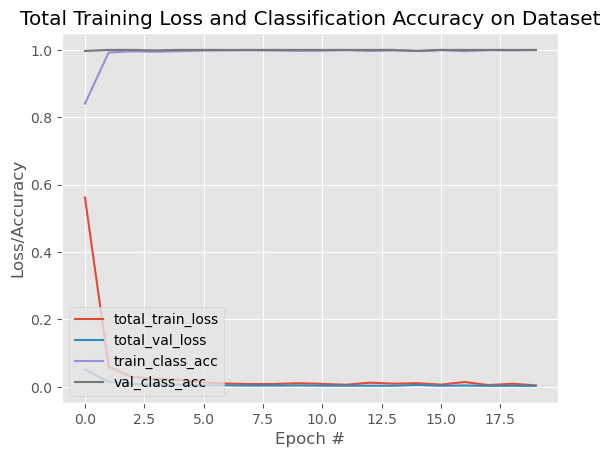

In [13]:
# serialize the model to disk
print("[INFO] saving object detector model...")
torch.save(objectDetector, config.MODEL_PATH)

# serialize the label encoder to disk
print("[INFO] saving label encoder...")
f = open(config.LE_PATH, "wb")
f.write(pickle.dumps(le))
f.close()

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(H["total_train_loss"], label="total_train_loss")
plt.plot(H["total_val_loss"], label="total_val_loss")
plt.plot(H["train_class_acc"], label="train_class_acc")
plt.plot(H["val_class_acc"], label="val_class_acc")
plt.title("Total Training Loss and Classification Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

# save the training plot
plotPath = os.path.sep.join([config.PLOTS_PATH, "training.png"])
plt.savefig(plotPath)

### Run predictions with the trained model

In [14]:
args = {
    "input": "dataset/images/airplane/image_0001.jpg"
}

In [15]:
from torchvision import transforms

# determine the input file type, but assume that we're working with
# single input image
filetype = mimetypes.guess_type(args["input"])[0]
imagePaths = [args["input"]]

# if the file type is a text file, then we need to process *multiple*
# images
if "text/plain" == filetype:
    # load the image paths in our testing file
    imagePaths = open(args["input"]).read().strip().split("\n")

# load our object detector, set it evaluation mode, and label
# encoder from disk
print("[INFO] loading object detector...")
model = torch.load(config.MODEL_PATH).to(config.DEVICE)
model.eval()
le = pickle.loads(open(config.LE_PATH, "rb").read())

# define normalization transforms
transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=config.MEAN, std=config.STD)
])

[INFO] loading object detector...


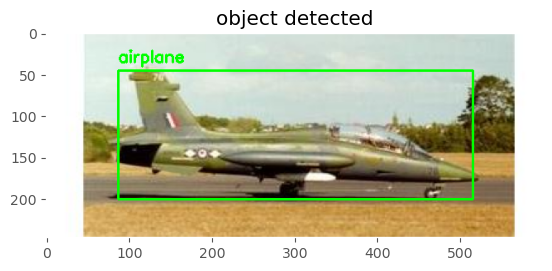

In [16]:
# loop over the images that we'll be testing using our bounding box
# regression model
for imagePath in imagePaths:
    # load the image, copy it, swap its colors channels, resize it, and
    # bring its channel dimension forward
    image = cv2.imread(imagePath)
    orig = image.copy()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    image = image.transpose((2, 0, 1))

    # convert image to PyTorch tensor, normalize it, flash it to the
    # current device, and add a batch dimension
    image = torch.from_numpy(image)
    image = transforms(image).to(config.DEVICE)
    image = image.unsqueeze(0)

    # predict the bounding box of the object along with the class
    # label
    (boxPreds, labelPreds) = model(image)
    (startX, startY, endX, endY) = boxPreds[0]

    # determine the class label with the largest predicted
    # probability
    labelPreds = torch.nn.Softmax(dim=-1)(labelPreds)
    i = labelPreds.argmax(dim=-1).cpu()
    label = le.inverse_transform(i)[0]

    # resize the original image such that it fits on our screen, and
    # grab its dimensions
    orig = imutils.resize(orig, width=600)
    (h, w) = orig.shape[:2]

    # scale the predicted bounding box coordinates based on the image
    # dimensions
    startX = int(startX * w)
    startY = int(startY * h)
    endX = int(endX * w)
    endY = int(endY * h)

    # draw the predicted bounding box and class label on the image
    y = startY - 10 if startY - 10 > 10 else startY + 10
    cv2.putText(orig, label, (startX, y), cv2.FONT_HERSHEY_SIMPLEX,
        0.65, (0, 255, 0), 2)
    cv2.rectangle(orig, (startX, startY), (endX, endY),
        (0, 255, 0), 2)

    # show the output image
    plt_imshow("object detected", orig)

For a detailed walkthrough of the concepts and code, be sure to refer to the full tutorial, [*Training an object detector from scratch in PyTorch*](https://www.pyimagesearch.com/2021/11/01/training-an-object-detector-from-scratch-in-pytorch/) published on 2021-11-01.

# Code License Agreement
```
Copyright (c) 2021 PyImageSearch.com

SIMPLE VERSION
Feel free to use this code for your own projects, whether they are
purely educational, for fun, or for profit. THE EXCEPTION BEING if
you are developing a course, book, or other educational product.
Under *NO CIRCUMSTANCE* may you use this code for your own paid
educational or self-promotional ventures without written consent
from Adrian Rosebrock and PyImageSearch.com.

LONGER, FORMAL VERSION
Permission is hereby granted, free of charge, to any person obtaining
a copy of this software and associated documentation files
(the "Software"), to deal in the Software without restriction,
including without limitation the rights to use, copy, modify, merge,
publish, distribute, sublicense, and/or sell copies of the Software,
and to permit persons to whom the Software is furnished to do so,
subject to the following conditions:
The above copyright notice and this permission notice shall be
included in all copies or substantial portions of the Software.
Notwithstanding the foregoing, you may not use, copy, modify, merge,
publish, distribute, sublicense, create a derivative work, and/or
sell copies of the Software in any work that is designed, intended,
or marketed for pedagogical or instructional purposes related to
programming, coding, application development, or information
technology. Permission for such use, copying, modification, and
merger, publication, distribution, sub-licensing, creation of
derivative works, or sale is expressly withheld.
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND,
EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES
OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND
NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS
BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN
ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
```